# KMeans Predictive Cluster Models for Crime Victim Analysis:
## A. C. Coffin 
### 11/10/2023
### Northwestern Missouri State University
### MS Data Analytics Capstone
---
### Introduction:

This section demonstrates the use of one of two clustering algorythms, on Crime Victim Data gathered from the NYPD and the NCVS Dashboard, specifically KMeans. The objective is to determine which model is the most successful at predictive clustering using both data sets, and then beginning a process of incremental learning. By taking the model trained on the NCVS data and fitting NYPD data, it is possible to exicute a process known as incremental learning. As crime data is extremily complex utilizing incremental learning will address inconcistencies that are common with crime data. 
---
## Importing packages and Addressing Threads:

In [1]:
from threadpoolctl import threadpool_info
from pprint import pprint
import numpy
pprint(threadpool_info())


[{'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\mkl_rt.1.dll',
  'internal_api': 'mkl',
  'num_threads': 6,
  'prefix': 'mkl_rt',
  'threading_layer': 'intel',
  'user_api': 'blas',
  'version': '2021.4-Product'}]


In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
pprint(threadpool_info())

[{'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\mkl_rt.1.dll',
  'internal_api': 'mkl',
  'num_threads': 6,
  'prefix': 'mkl_rt',
  'threading_layer': 'intel',
  'user_api': 'blas',
  'version': '2021.4-Product'},
 {'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\libiomp5md.dll',
  'internal_api': 'openmp',
  'num_threads': 12,
  'prefix': 'libiomp',
  'user_api': 'openmp',
  'version': None}]


In [91]:
# When running this notebook, comment out yellowbrick, as it interfears with the performance of matplotlib and seaborne. 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
#%matplotlib inline
#import plotly.express as px
#import folium
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-Processing:
All of the data within these crime sets is catagorical in nature and as a result was proceed differently. Part of pre-processing was grouping crime types together, as well as removing those which didn't apply to specific models. When addressing the grouping of data within the NYPD dataset, crimes were coordinated based on the general type of crime and severity. The grouping of key codes is explained in the following table, along with thier offense description. The data pulled from the NCVS pertains to mainly Personal Crimes, such as sexual assault, robbery, aggrivated assault and simple assault. In order to make the data found within the NYPD data to be compatible with the incremental learning to occur, these crimes were once again grouped and sorted based on the types found in the NCVS data. Data pertaining to age groups has already been seperated, with an adjustment made to the NCVS data to group minors together as that data in particular breaks the age groups apart indepth. All null values found within the NYPD data for age have been removed, it was included within analysis to visualize the amount of known data in comparison to the unknown within the filtered set.

## Modifications Made to both NCVS and NYPD Data:
Please see the following charts for the modified ML sets. Each of these set was exported from the SQL server independently and labeled ML for this specific section of the project. Victims with a listed age of N/A were put into class 6 for Age_GM. This is in response to how depending on the crime victim ages are ommited for safety, espcially since the NYPD data has associated case numbers in the original set. 

Modifications to Age Groups within the NCVS data is as follows:
|AGE_GM|NCVS Age Groups|New Range|
|:---|:---|:---|
|1 |12-14, 15-17| >18|
|2 |18-20, 21-24| 18-25|
|3 |25-34, 35-49| 25-49|
|4 |50-64| 50-64|
|5 | 65+ | 65+|
|5 |Unknown| Unknown|

Modifications to NYPD data as NCIC Codes and CT_M:
|NCIC|KY_CD|OFNS_DESC|CT_M|CT_M Meaning
|:---|:---|:---|:---|:---|
|1011 |104, 115, 116, 235|Sex Crimes| 2| Violent Crime Except Simple Assault|
|1201 |105, 107, 109-113, 231, 313, 340-343| Robbery/Fraud| 2| Violent Crime Except Simple Assault|
|1301 |101, 103, 106, 114| Homicide/Aggrivated Assault| 2| Violent Crime Except Simple Assault|
|1313 |344, 578, 230, 355| Simple Assault/Related Crimes| 1| Simple Assault|

Data pertaining to Public or Society Crimes, such as driving under the influence, traffic violations, child abandonment, pocession of a deadly weapon or drug pocessions have been removed from this data. This was done as the NCVS data pulled only pertains to Personal Crimes. This data was utilized both through the initial run of the models and again when being fitted to the selected NCVS model. The only difference is that when the NYPD data was fitted to the NCVS model the NCIC model was used. This was to demonstrate the differences between the sets as a whole. 

---
# NCVS Baseline:
As this Analysis relies heavily on the comparison of National Data to Regional Data to explore crime in america as well as demonstrate a possible application of machine learning, creating a baseline is critical. For this section each of the models has been run three times on the pre-processed NCVS data. There are two major data sets which will be used, the first being the NCVS_RegionalML Data, and the second being the NCVS_AgeSegML. 

## Importing NCVS Data:
All data for each of the sets being analysize has been brought in independently to decrease processing load.


In [48]:
NCVS_AgeSeg = pd.read_csv('Data/ML_PreProcess/NCVS_AgeSegML.csv', index_col= 'rpt_dt')
NCVS_Region = pd.read_csv('Data/ML_PreProcess/NCVS_RegionSegML.csv', index_col='rpt_dt')


In [49]:
NCVS_AgeSeg.describe()

age_gm         ncic       vic_num
count  960.000000   960.000000  9.600000e+02
mean     2.625000  1229.000000  1.189906e+05
std      1.317643    85.788498  1.729374e+05
min      1.000000  1101.000000  0.000000e+00
25%      1.750000  1176.000000  2.345025e+04
50%      2.500000  1251.000000  5.639350e+04
75%      3.250000  1304.000000  1.287462e+05
max      5.000000  1313.000000  1.286595e+06

In [50]:
NCVS_Region.describe()

region_m         ncic       vic_num
count  432.00000   432.000000  4.320000e+02
mean     2.50000  1229.000000  2.157819e+05
std      1.11933    85.843218  2.420097e+05
min      1.00000  1101.000000  1.010800e+04
25%      1.75000  1176.000000  6.804000e+04
50%      2.50000  1251.000000  1.067280e+05
75%      3.25000  1304.000000  2.738938e+05
max      4.00000  1313.000000  1.355884e+06

# Scaling data:

In [51]:
# Dropping rows with NA values in any columns
NCVS_AgeSeg.dropna(inplace=True)

# Creating a scaled df where each value has a mean of 0 and stdev of 1
from sklearn import preprocessing
scaler = StandardScaler()
NCVS_AgeSeg[["age_gm_T", "ncic_T", "vic_num_T"]] = scaler.fit_transform(NCVS_AgeSeg[["age_gm", "ncic", "vic_num"]])


In [52]:
NCVS_AgeSeg

age_gm  ncic  vic_num  age_gm_T    ncic_T  vic_num_T
rpt_dt                                                      
1993         1  1101    47196 -1.233905 -1.492819  -0.415364
1994         1  1101    49561 -1.233905 -1.492819  -0.401682
1995         1  1101    38205 -1.233905 -1.492819  -0.467381
1996         1  1101    28399 -1.233905 -1.492819  -0.524113
1997         1  1101    50766 -1.233905 -1.492819  -0.394710
...        ...   ...      ...       ...       ...        ...
2018         5  1313   101597  1.803400  0.979663  -0.100630
2019         5  1313    81683  1.803400  0.979663  -0.215841
2020         5  1313    66542  1.803400  0.979663  -0.303439
2021         5  1313   109392  1.803400  0.979663  -0.055532
2022         5  1313   181253  1.803400  0.979663   0.360216

[960 rows x 6 columns]

In [53]:
# Dropping rows with NA values in any columns
NCVS_Region.dropna(inplace=True)

# Creating a scaled df where each value has a mean of 0 and stdev of 1
from sklearn import preprocessing
scaler = StandardScaler()
NCVS_Region[["region_m_T", "ncic_T", "vic_num_T"]] = scaler.fit_transform(NCVS_Region[["region_m", "ncic", "vic_num"]])

#Review scaled rows of the df
print(NCVS_Region)

        region_m  ncic  vic_num  region_m_T    ncic_T  vic_num_T
rpt_dt                                                          
1996           2  1101   145675   -0.447214 -1.492819  -0.290022
1997           2  1101   210209   -0.447214 -1.492819  -0.023054
1998           2  1101   120428   -0.447214 -1.492819  -0.394465
1999           2  1101   143786   -0.447214 -1.492819  -0.297837
2000           2  1101    64034   -0.447214 -1.492819  -0.627759
...          ...   ...      ...         ...       ...        ...
2018           1  1313   264179   -1.341641  0.979663   0.200212
2019           1  1313   297763   -1.341641  0.979663   0.339144
2020           1  1313   203401   -1.341641  0.979663  -0.051218
2021           1  1313   201060   -1.341641  0.979663  -0.060902
2022           1  1313   382218   -1.341641  0.979663   0.688522

[432 rows x 6 columns]


In [54]:
NCVS_Region.describe()

region_m         ncic       vic_num  region_m_T        ncic_T  \
count  432.00000   432.000000  4.320000e+02  432.000000  4.320000e+02   
mean     2.50000  1229.000000  2.157819e+05    0.000000  9.663052e-17   
std      1.11933    85.843218  2.420097e+05    1.001159  1.001159e+00   
min      1.00000  1101.000000  1.010800e+04   -1.341641 -1.492819e+00   
25%      1.75000  1176.000000  6.804000e+04   -0.670820 -6.181205e-01   
50%      2.50000  1251.000000  1.067280e+05    0.000000  2.565783e-01   
75%      3.25000  1304.000000  2.738938e+05    0.670820  8.746988e-01   
max      4.00000  1313.000000  1.355884e+06    1.341641  9.796626e-01   

          vic_num_T  
count  4.320000e+02  
mean  -4.111937e-17  
std    1.001159e+00  
min   -8.508435e-01  
25%   -6.111871e-01  
50%   -4.511404e-01  
75%    2.404003e-01  
max    4.716439e+00

## K-Means Model:
There are a number of clustering models used for data anlysis, one of these models is the kmeans model. The objective of the model is to assign data points to clusters, based on proximity to a centroid. By doing so it explores the association between data points based on distance calculations between groups. The model opperates under the assumption that the cluster is spherical in nature, equally size and has similar dencities. Analysizing crime statistics as well as conceptualizing the actual precence of crime in US society, clustering is often used. The reason is that crime classifications are based on a group of characteristics that are requried for a crime to be considered one class or another. As this data is based on catagorical structure, as opposed to an interval clustering is possible. It is important to note that while in the case of crime, is that while Offenses do carry an ordinal weight within socity, this weight is difficult to build into a model without adding an extra layer or catagory. 

K-Means has limitations, as it performs poorly when clusters are irregular in size, shape and decnity. As the alogrythem itself is based on distance calculations from a centroid, it can be sensitive to the initial placement of a cluster, and even interpret outliers with greater impact than necessary. This is why the analysis begins with K-Means but has an added layer with DBSCAN. 

# Age Segmentation:

In [55]:
# Estimating the number of clusters using KMeans:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans=KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    #Generate the plot
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, '|-')
    plt.title('NCVS AgeSeg Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

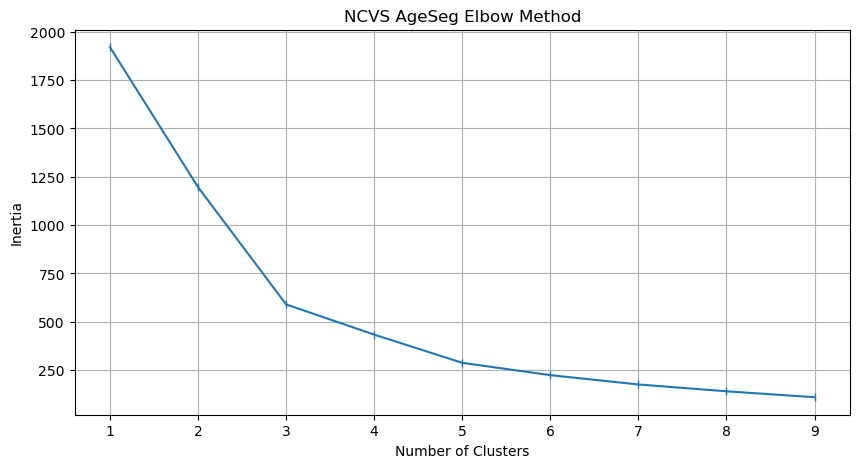

In [36]:
optimise_k_means(NCVS_AgeSeg[['age_gm_T', 'vic_num_T']], 10)

Based on the elbow provided, the number of clusters appropriate to use with this data is 4.

## Applying K-Means

In [37]:
# Creating the model to analysize the data:
kmeansAG= KMeans(n_clusters=4)


In [38]:
kmeansAG.fit(NCVS_AgeSeg[['age_gm_T', 'vic_num_T']])

KMeans(n_clusters=4)

In [39]:
NCVS_AgeSeg['KMeans_4'] = kmeansAG.labels_
NCVS_AgeSeg

age_gm  ncic  vic_num  age_gm_T    ncic_T  vic_num_T  KMeans_4
rpt_dt                                                                
1993         1  1101    47196 -1.233905 -1.492819  -0.415364         2
1994         1  1101    49561 -1.233905 -1.492819  -0.401682         2
1995         1  1101    38205 -1.233905 -1.492819  -0.467381         2
1996         1  1101    28399 -1.233905 -1.492819  -0.524113         2
1997         1  1101    50766 -1.233905 -1.492819  -0.394710         2
...        ...   ...      ...       ...       ...        ...       ...
2018         5  1313   101597  1.803400  0.979663  -0.100630         1
2019         5  1313    81683  1.803400  0.979663  -0.215841         1
2020         5  1313    66542  1.803400  0.979663  -0.303439         1
2021         5  1313   109392  1.803400  0.979663  -0.055532         1
2022         5  1313   181253  1.803400  0.979663   0.360216         1

[960 rows x 7 columns]

## Scatter Plot of Data:

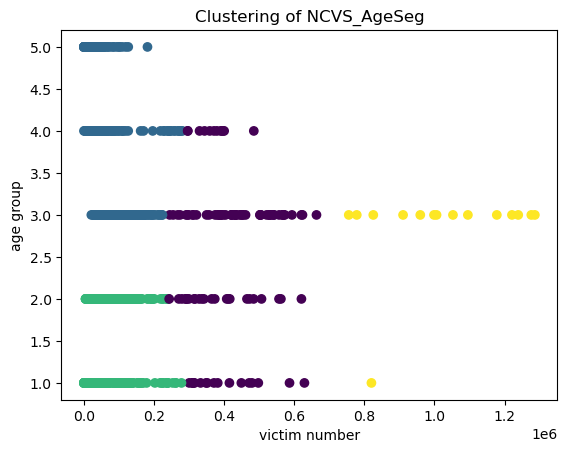

In [40]:
# Creating a kmeans scatter:
plt.scatter(x=NCVS_AgeSeg['vic_num'], y=NCVS_AgeSeg['age_gm'], c=NCVS_AgeSeg['KMeans_4'])
plt.title("Clustering of NCVS_AgeSeg")
plt.xlabel("victim number")
plt.ylabel("age group")
plt.show()

# Silhouette Coefficient and Calinski-Harabase Index:
To verify the data's performance three metrics were utilized, the Silhouette Score Average, a Silhouette Coefficient Visualization, the Calinzki-Harabase Index and the Davies-Bouldin Index. All three methods were selected as each does not require the caluculation of ground-truth clusters. While it is possible to calculate these clusters, with this particular form of data utilizing fixed centriols is not effective. Additionally the Calinski-Harabasz score creates a ratio comparing inter-clustering and intra-clustering distances, to determine if the clusters are compact and seperated. This metric is traditonally used with DBSCAN, however has also been added as a facet of the KMeans Analysis. The Davies-Bouldin Index compares the averag similarity between clusters pairwise by comparing similar clsuters. The result of Davies_Bouldin is that clusters with less dispersion have a better score, while those that are more dispersed have a weaker score. The higher the value for DBI the poorer the clsutering solutions. The lower the DBI the more compact and well seperated clusters indicates success. 

In [88]:
#Silhouette Score
# Establishing x and y
x = NCVS_AgeSeg.iloc[:,3:5].values


model = KMeans(n_clusters = 4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = model.fit_predict(x)
labels = model.labels_


In [57]:
# Sihouette score
silhouette_score_average = silhouette_score(x, model.predict(x))
print(silhouette_score_average)

0.5206965454588184


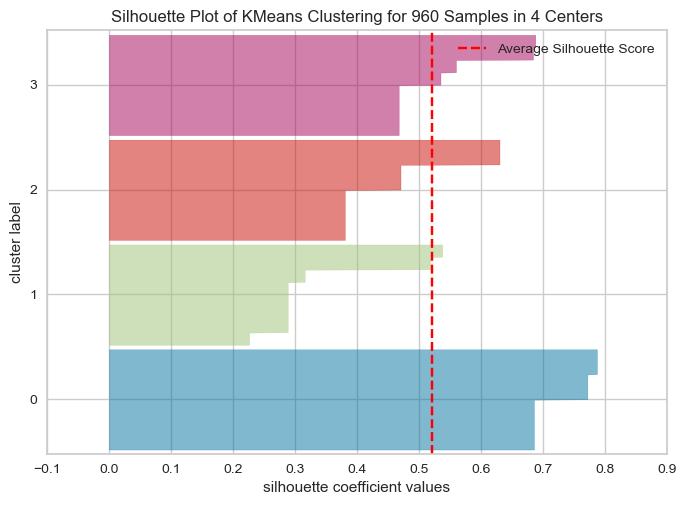

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 960 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [58]:
# Creating a visual of Sihouette:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x)
visualizer.show()


In [94]:
# Calinski-Harabase Index:
ch_score = calinski_harabasz_score(x, labels)

# Davies Boudlin
db_score = davies_bouldin_score(x, labels)

#Silhouette Score:
silhouette_score_average = silhouette_score(x, model.predict(x))

print(f"The Calinski-Harabasz Score for the NCVS_AgeSeg set is {ch_score}.")
print(f"The Davies-Bouldin Score for the NCVS_AgeSeg set is: {db_score}")
print(f"The Silhouette Score Agerage for the NCVS_AgeSeg set is: {silhouette_score_average}")

The Calinski-Harabasz Score for the NCVS_AgeSeg set is 1120.852768275266.
The Davies-Bouldin Score for the NCVS_AgeSeg set is: 0.7923475356685683
The Silhouette Score Agerage for the NCVS_AgeSeg set is: 0.5206965454588184


# Silhouette:
When examining how the data is clustering for the NCVS_AgeSeg, it simportant to note that a majority of the data falls into the 3rd cluster when examining a 5 cluster model. While 4 is considered the optimal number of clusters according to the Elbow method. However, when examining the Silhouette score of the clustering the number of clusters that performs better is actually 5 as more of the clusters are above the average silhouette score. 

# NCVS_AgeSeg data exploring other values of k

In [55]:
# Splitting using different K values
for k in range(1, 6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(NCVS_AgeSeg[['age_gm_T', 'vic_num_T']])
    NCVS_AgeSeg[f'KMeans_{k}'] = kmeans.labels_

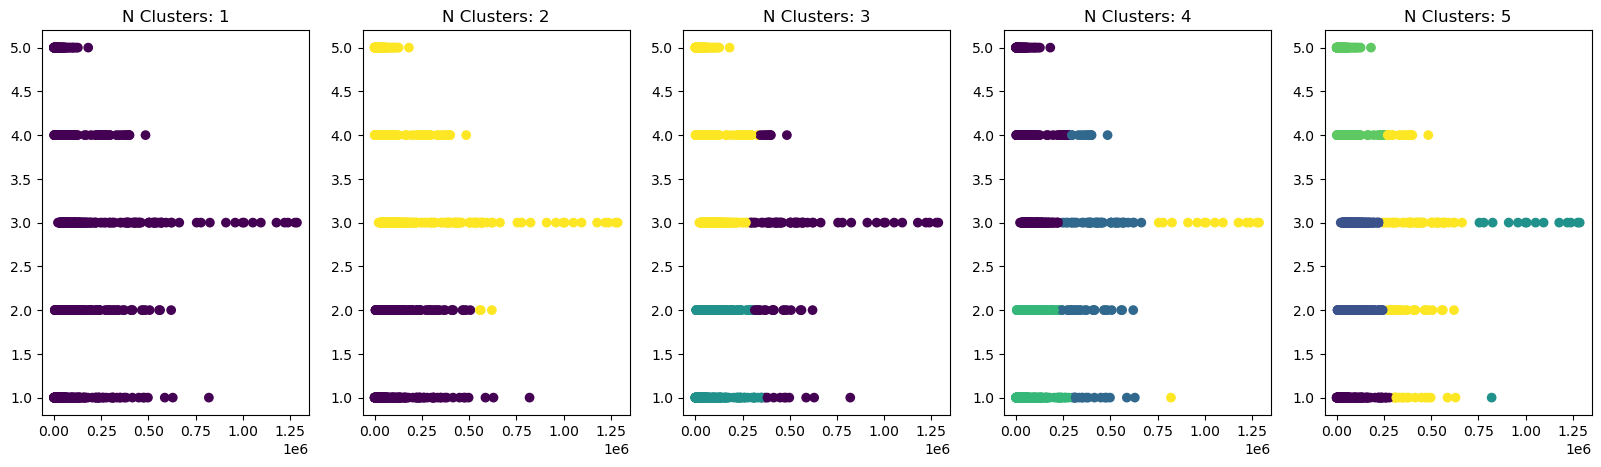

In [56]:
# Sub plots
%matplotlib inline
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=NCVS_AgeSeg['vic_num'], y=NCVS_AgeSeg['age_gm'], c=NCVS_AgeSeg[f'KMeans_{i}'])
    ax.set_title(f'N Clusters: {i}')

As noted the data in this case doesn't cluster well as there are too few data instances accross the age groups to perform this type of analysis. Additionally as all of this data is drastic when comparing age groups to the number of victims, when scaling is applied it distorts the data. As this is a simple data set, the clustering does take the from of bars, this is because there are 5 age groups, as well as the fact that the data has very few entries and is focused as a total number of victims rather than independent entries. 

## Regional KMeans based on NCVS Data

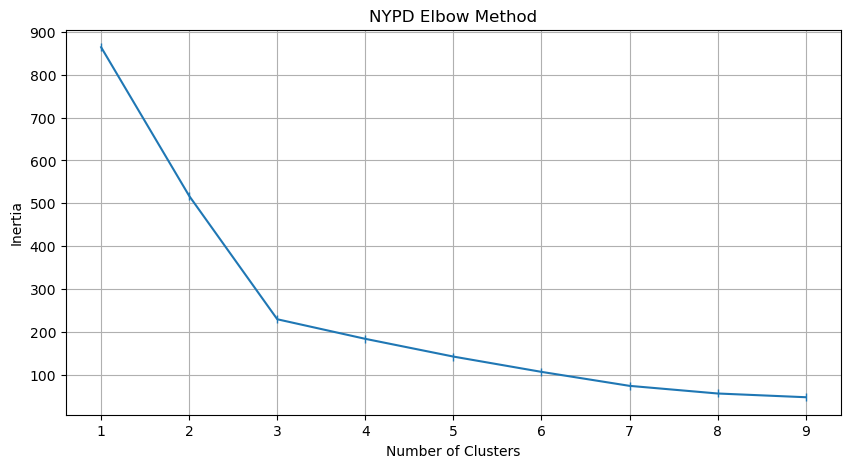

In [73]:
optimise_k_means(NCVS_Region[['region_m_T', 'vic_num_T']], 10)

Optimal number of clusters is 3.

In [59]:
# Creating the model to analysize the data:
kmeans= KMeans(n_clusters=3)



In [48]:
# fitting data to model based on region and number of victims
kmeans.fit(NCVS_Region[['region_m_T', 'vic_num_T']])

# establishing kmeans column
NCVS_Region['kmeans_3'] = kmeans.labels_
NCVS_Region

region_m  ncic  vic_num  region_m_T    ncic_T  vic_num_T  kmeans_3
rpt_dt                                                                    
1996           2  1101   145675   -0.447214 -1.492819  -0.290022         2
1997           2  1101   210209   -0.447214 -1.492819  -0.023054         2
1998           2  1101   120428   -0.447214 -1.492819  -0.394465         2
1999           2  1101   143786   -0.447214 -1.492819  -0.297837         2
2000           2  1101    64034   -0.447214 -1.492819  -0.627759         2
...          ...   ...      ...         ...       ...        ...       ...
2018           1  1313   264179   -1.341641  0.979663   0.200212         2
2019           1  1313   297763   -1.341641  0.979663   0.339144         2
2020           1  1313   203401   -1.341641  0.979663  -0.051218         2
2021           1  1313   201060   -1.341641  0.979663  -0.060902         2
2022           1  1313   382218   -1.341641  0.979663   0.688522         2

[432 rows x 7 columns]

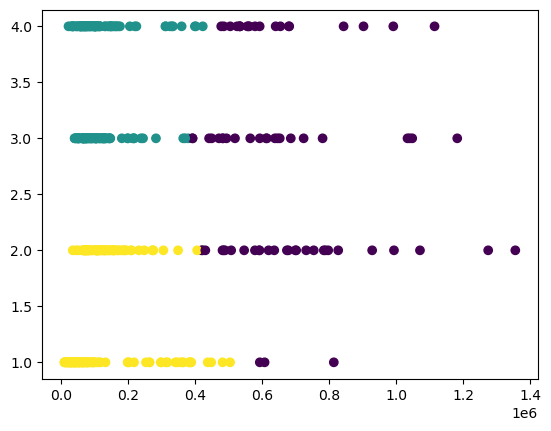

In [50]:
# Creating a kmeans scatter:
plt.scatter(x=NCVS_Region['vic_num'], y=NCVS_Region['region_m'], c=NCVS_Region['kmeans_3'])
plt.show()

In [60]:
for k in range(1, 6):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(NCVS_Region[['region_m_T', 'vic_num_T']])
    NCVS_Region[f'KMeans_{k}'] = kmeans.labels_

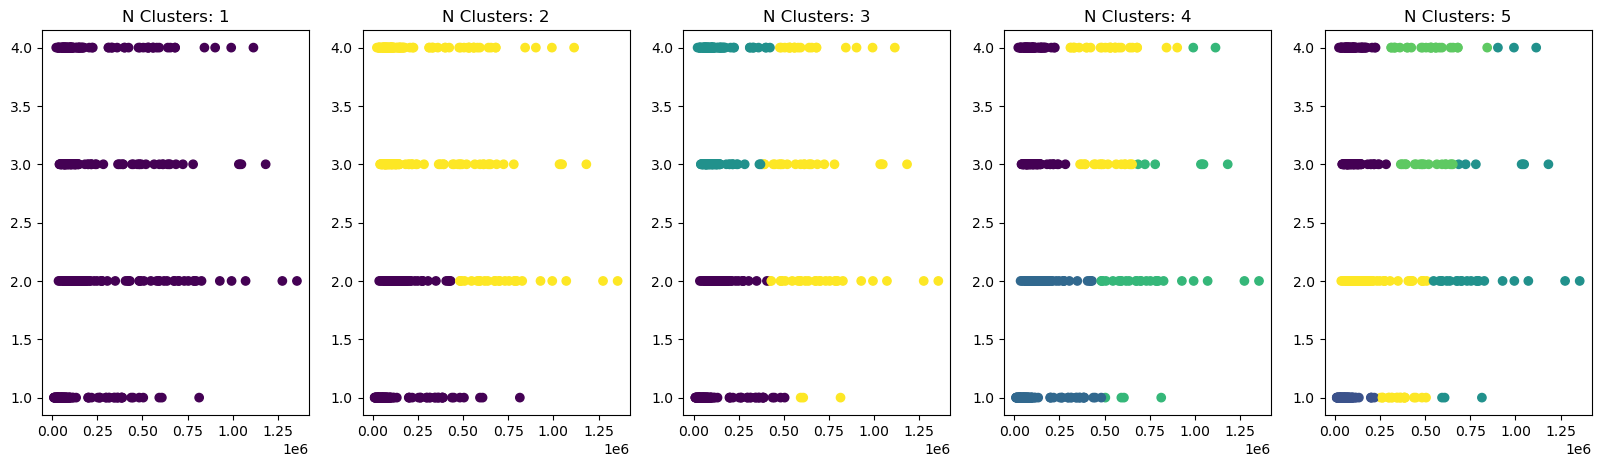

In [61]:
# Sub plots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=NCVS_Region['vic_num'], y=NCVS_Region['region_m'], c=NCVS_Region[f'KMeans_{i}'])
    ax.set_title(f'N Clusters: {i}')

In [101]:
#Silhouette Score
# Establishing x by selecting the columns 5 through 7 holding transformed data
x = NCVS_Region.iloc[:, 3:5].values
y = NCVS_Region.iloc[:, 5]


model = KMeans(n_clusters = 4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = model.fit_predict(x)
labels = model.labels_

# Sihouette score
silhouette_score_average = silhouette_score(x, model.predict(x))
print(silhouette_score_average)

0.5668840006371114


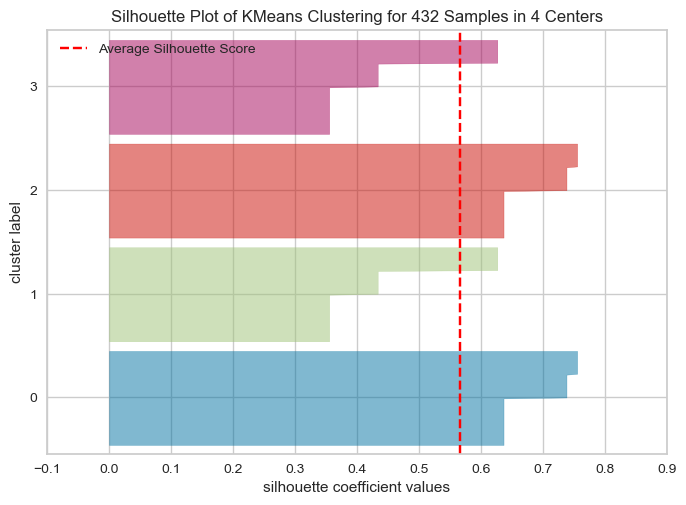

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 432 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [65]:
# Creating a visual of Sihouette:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x)
visualizer.show()

In [102]:
# Calinski-Harabase Index:
ch_score = calinski_harabasz_score(x, labels)

# Davies Boudlin
db_score = davies_bouldin_score(x, labels)

#Silhouette Score:
silhouette_score_average = silhouette_score(x, model.predict(x))

print(f"The Calinski-Harabasz Score for the NCVS_Region set is {ch_score}.")
print(f"The Davies-Bouldin Score for the NCVS_Region set is: {db_score}")
print(f"The Silhouette Score Agerage for the NCVS_Region set is: {silhouette_score_average}")

The Calinski-Harabasz Score for the NCVS_AgeSeg set is 623.390398286106.
The Davies-Bouldin Score for the NCVS_AgeSeg set is: 0.7371657787363654
The Silhouette Score Agerage for the NCVS_AgeSeg set is: 0.5668840006371114


## Silhouette of NCVS Region:
While when initially plotting inertia the data indicated that 3 clusters would yield better results, in reality the use of 6 clusters, is more effective. Even though the data is not evenly disperced. This is because the shape of the data is less of a circular cluster and more of a bar, which is more appropriatly analysize using DBSCAN. However, when utilizing 6 clusters there is a lot of encroachment between the clusters and isn't effective.


# NYPD Models:
The data for the NYPD models will be used from the NYPDv4ML file. This file has been cleaned but hasn't been narrowed in scope as much as the data used by the NCVS data. It is important to remember that the catagories that the NCVS data covers is considerably smaller, and results in a less dispersed scatter plot. Where as the NYPD Data has a larger amount of variation as the subclasses of these crimes have been kept. 

# K-Means Analysis:

In [4]:
NYPD = pd.read_csv('Data/ML_PreProcess/NYPDv4ML.csv', index_col= 'rpt_num')


In [5]:
NYPD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87024 entries, 261177965 to 268067163H1
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   addr_pct_cd               87024 non-null  int64  
 1   boro_nm                   87024 non-null  object 
 2   boro_num                  87024 non-null  int64  
 3   rpt_fr_de                 87024 non-null  object 
 4   rpt_fr_dtm                87024 non-null  int64  
 5   crm_atpt_cptd_cd          87024 non-null  object 
 6   ky_cd                     87024 non-null  int64  
 7   ct_m                      87024 non-null  int64  
 8   ncic                      87024 non-null  int64  
 9   ofns_desc                 87024 non-null  object 
 10  pd_cd                     87003 non-null  float64
 11  pd_desc                   87024 non-null  object 
 12  age_group                 87024 non-null  object 
 13  age_gm                    87024 non-null  int64  
 1

In [6]:
NYPD.describe()

addr_pct_cd      boro_num    rpt_fr_dtm         ky_cd          ct_m  \
count  87024.000000  87024.000000  87024.000000  87024.000000  87024.000000   
mean      64.895604      2.596606  44991.483143    347.930881      1.626103   
std       33.777105      1.169814    278.749207    178.900704      0.483840   
min        1.000000      1.000000  33970.000000    101.000000      1.000000   
25%       41.000000      2.000000  44966.000000    112.000000      1.000000   
50%       66.000000      3.000000  45014.000000    344.000000      2.000000   
75%      101.000000      4.000000  45060.000000    578.000000      2.000000   
max      123.000000      5.000000  45107.000000    578.000000      2.000000   

               ncic         pd_cd        age_gm    x_coord_cd    y_coord_cd  \
count  87024.000000  87003.000000  87024.000000  8.702400e+04   87024.00000   
mean    1261.304698    414.866832      3.162921  1.006491e+06  208326.94875   
std       62.215905    219.634816      1.028758  2.164090e+04   30874.37923   
min     1101.000000    100.000000      1.000000  9.139600e+05  121390.00000   
25%     1201.000000    175.000000      3.000000  9.950700e+05  184324.00000   
50%     1301.000000    412.000000      3.000000  1.006159e+06  207247.00000   
75%     1313.000000    638.000000      4.000000  1.018624e+06  237140.00000   
max     1313.000000    878.000000      6.000000  1.067226e+06  271730.00000   

                lat           lon  
count  87024.000000  87024.000000  
mean      40.738433    -73.919710  
std        0.084746      0.078047  
min       40.499616    -74.252751  
25%       40.672568    -73.961004  
50%       40.735446    -73.920940  
75%       40.817548    -73.875904  
max       40.912468    -73.700565

## Geographic Visual

In [42]:
# Creating GeoSpatcial map to examine number of reports from 1993 to 2023 in NYC
lat_lon = NYPD[['lat', 'lon']]
lat, longg = NYPD.lat, NYPD.lon

px.scatter(NYPD, x='lon', y='lat')

In [7]:
# Dropping rows with NA values in any columns
NYPD.dropna(inplace=True)

# Creating a scaled df where each value has a mean of 0 and stdev of 1
from sklearn import preprocessing
scaler = StandardScaler()
NYPD[["age_gm_T", "ky_cd_T", "addr_pct_cd_T", "rpt_fr_dtm_T"]] = scaler.fit_transform(NYPD[["age_gm", "ky_cd", "addr_pct_cd", "rpt_fr_dtm"]])


## Determining the Number of Clusters

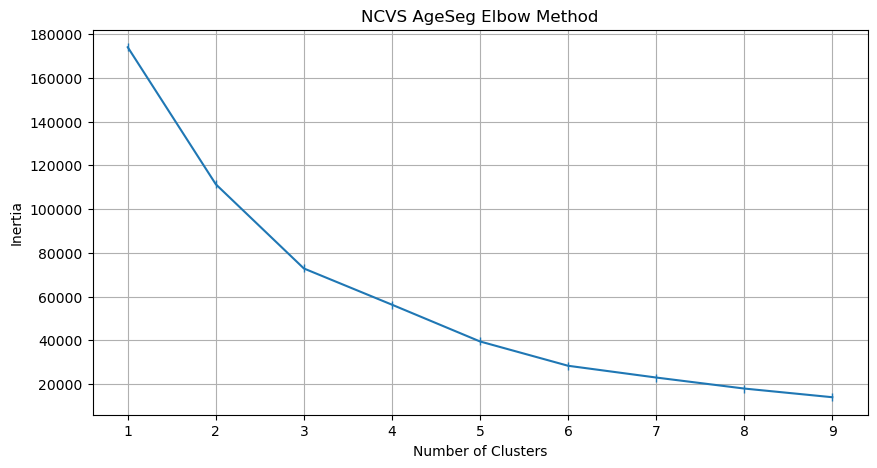

In [10]:
optimise_k_means(NYPD[['ky_cd_T', 'age_gm_T']], 10)

# NYPD Number of Clusters according to Elbow:
In this instance the number of clusters suggested by the graph is 3 clusters. 

In [11]:
# Creating the model to analysize the data: Examining Date and key code relationship
kmeans= KMeans(n_clusters=3)

# fitting data to model based on crime code and age
kmeans.fit(NYPD[['ky_cd_T', 'age_gm_T']])

# establishing kmeans column
NYPD['kmeans_3'] = kmeans.labels_
NYPD

addr_pct_cd        boro_nm  boro_num   rpt_fr_de  rpt_fr_dtm  \
rpt_num                                                                   
261177965           17      MANHATTAN         1  12/31/2022       44926   
261196077           75       BROOKLYN         2    1/1/2023       44927   
261233709           81       BROOKLYN         2    1/2/2023       44928   
261236460           67       BROOKLYN         2    1/2/2023       44928   
261253958           73       BROOKLYN         2    1/2/2023       44928   
...                ...            ...       ...         ...         ...   
270480486           45          BRONX         3   6/27/2023       45104   
270630213           83       BROOKLYN         2    9/1/2022       44805   
270643747           47          BRONX         3   6/20/2022       44732   
266087385          120  STATEN ISLAND         5    4/3/2023       45019   
266719984           23      MANHATTAN         1   4/15/2023       45031   

          crm_atpt_cptd_cd  ky_cd  ct_m  ncic                       ofns_desc  \
rpt_num                                                                         
261177965        COMPLETED    578     1  1313                   HARRASSMENT 2   
261196077        COMPLETED    578     1  1313                   HARRASSMENT 2   
261233709        COMPLETED    578     1  1313                   HARRASSMENT 2   
261236460        COMPLETED    578     1  1313                   HARRASSMENT 2   
261253958        COMPLETED    578     1  1313                   HARRASSMENT 2   
...                    ...    ...   ...   ...                             ...   
270480486        COMPLETED    104     2  1101                            RAPE   
270630213        COMPLETED    104     2  1101                            RAPE   
270643747        COMPLETED    104     2  1101                            RAPE   
266087385        COMPLETED    103     2  1301  HOMICIDE-NEGLIGENT,UNCLASSIFIE   
266719984        COMPLETED    103     2  1301  HOMICIDE-NEGLIGENT,UNCLASSIFIE   

           ...  y_coord_cd        lat        lon  \
rpt_num    ...                                     
261177965  ...      214547  40.755557 -73.973048   
261196077  ...      181866  40.665808 -73.892329   
261233709  ...      191029  40.690991 -73.935150   
261236460  ...      181044  40.663578 -73.924986   
261253958  ...      182105  40.666486 -73.921619   
...        ...         ...        ...        ...   
270480486  ...      241976  40.830722 -73.827126   
270630213  ...      193757  40.698474 -73.917769   
270643747  ...      262584  40.887314 -73.847272   
266087385  ...      174240  40.644892 -74.088341   
266719984  ...      229191  40.795739 -73.942680   

                                         lat_lon  \
rpt_num                                            
261177965                (40.755557, -73.973048)   
261196077                (40.665808, -73.892329)   
261233709                 (40.690991, -73.93515)   
261236460                (40.663578, -73.924986)   
261253958                (40.666486, -73.921619)   
...                                          ...   
270480486  (40.8307223277672, -73.8271260588639)   
270630213   (40.6984738177025, -73.917768981221)   
270643747  (40.8873136344706, -73.8472717577564)   
266087385                (40.644892, -74.088341)   
266719984                 (40.795739, -73.94268)   

                             new georeferenced column  age_gm_T   ky_cd_T  \
rpt_num                                                                     
261177965                POINT (-73.973048 40.755557)  2.757959  1.285831   
261196077                POINT (-73.892329 40.665808)  2.757959  1.285831   
261233709                 POINT (-73.93515 40.690991)  2.757959  1.285831   
261236460                POINT (-73.924986 40.663578)  2.757959  1.285831   
261253958                POINT (-73.921619 40.666486)  2.757959  1.285831   
...                                               ...       ...       ...   
270480486  

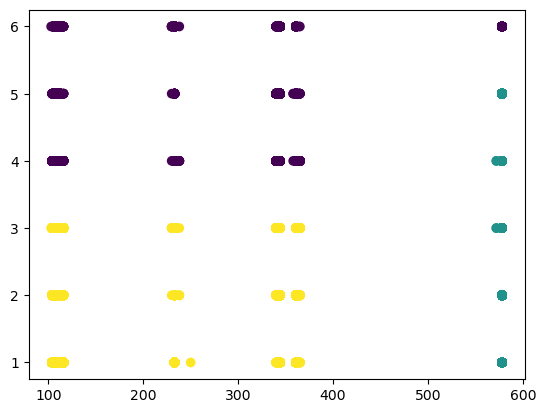

In [13]:
# Creating a kmeans scatter:
%matplotlib inline
plt.scatter(x=NYPD['ky_cd'], y=NYPD['age_gm'], c=NYPD['kmeans_3'])
plt.show()

In [ ]:
for k in range(1, 8):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(NYPD[['ky_cd_T', 'age_gm_T']])
    NYPD[f'KMeans_{k}'] = kmeans.labels_

KeyError: 'KMeans_6'

Error in callback <function _draw_all_if_interactive at 0x0000022DA34A25E0> (for post_execute):


KeyboardInterrupt: 

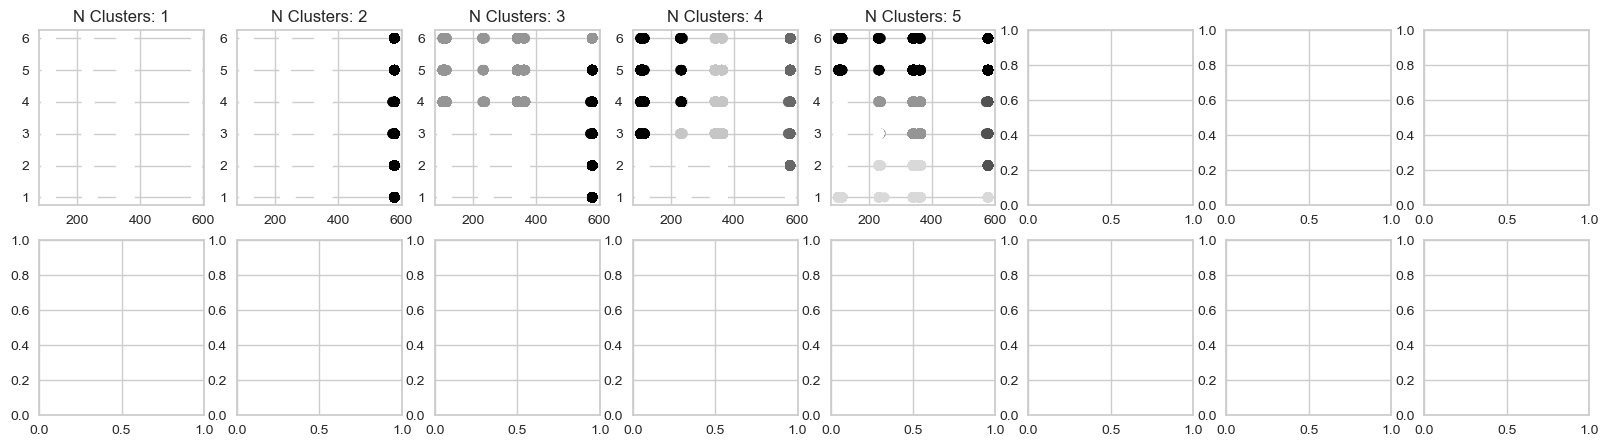

In [118]:
# Sub plots
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=NYPD['ky_cd'], y=NYPD['age_gm'], c=NYPD[f'KMeans_{i}'])
    ax.set_title(f'N Clusters: {i}')

In [20]:
NYPD.columns

Index(['addr_pct_cd', 'boro_nm', 'boro_num', 'rpt_fr_de', 'rpt_fr_dtm',
       'crm_atpt_cptd_cd', 'ky_cd', 'ct_m', 'ncic', 'ofns_desc', 'pd_cd',
       'pd_desc', 'age_group', 'age_gm', 'x_coord_cd', 'y_coord_cd', 'lat',
       'lon', 'lat_lon', 'new georeferenced column', 'age_gm_T', 'ky_cd_T',
       'addr_pct_cd_T', 'rpt_fr_dtm_T', 'kmeans_3', 'KMeans_1', 'KMeans_2',
       'KMeans_3', 'KMeans_4', 'KMeans_5'],
      dtype='object')

In [21]:
# Creating df for silhouette:
selected_columns = ['age_gm_T', 'ky_cd_T', 'addr_pct_cd_T', 'rpt_fr_dtm_T']
new_NYPD = NYPD[selected_columns].copy()

In [22]:
new_NYPD

age_gm_T   ky_cd_T  addr_pct_cd_T  rpt_fr_dtm_T
rpt_num                                                   
261177965  2.757959  1.285831      -1.417985     -0.234915
261196077  2.757959  1.285831       0.299215     -0.231328
261233709  2.757959  1.285831       0.476856     -0.227740
261236460  2.757959  1.285831       0.062359     -0.227740
261253958  2.757959  1.285831       0.240001     -0.227740
...             ...       ...            ...           ...
270480486 -2.102452 -1.363989      -0.588992      0.403591
270630213 -2.102452 -1.363989       0.536070     -0.668955
270643747 -2.102452 -1.363989      -0.529778     -0.930814
266087385  2.757959 -1.369579       1.631524      0.098687
266719984 -0.158288 -1.369579      -1.240343      0.141732

[87003 rows x 4 columns]

In [114]:
#Silhouette Score
# Establishing x and y
x = new_NYPD.iloc[:, :-1].values


model2 = KMeans(n_clusters = 5, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = model2.fit_predict(x)
labels = model2.labels_



In [115]:
# Sihouette score
silhouette_score_average = silhouette_score(x, model2.predict(x))
print(silhouette_score_average)

0.2772292673514983


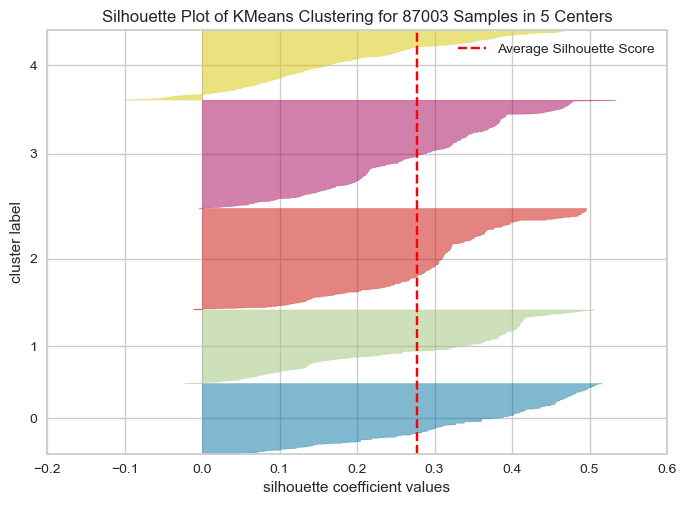

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 87003 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [117]:
# Creating a visual of Sihouette:
visualizer = SilhouetteVisualizer(model2, colors='yellowbrick')
visualizer.fit(x)
visualizer.show()

In [116]:
# Calinski-Harabase Index:
ch_score = calinski_harabasz_score(x, labels)

# Davies Boudlin
db_score = davies_bouldin_score(x, labels)

#Silhouette Score:
silhouette_score_average = silhouette_score(x, model2.predict(x))

print(f"The Calinski-Harabasz Score for the NYPD set is {ch_score}.")
print(f"The Davies-Bouldin Score for the NYPD set is: {db_score}")
print(f"The Silhouette Score Agerage for the NYPD set is: {silhouette_score_average}")

The Calinski-Harabasz Score for the NYPD set is 30539.13874923738.
The Davies-Bouldin Score for the NYPD set is: 1.1210168171193915
The Silhouette Score Agerage for the NYPD set is: 0.2772292673514983


# Modified NYPD Data:
This section is to demonstrate the impact that data format has on analysis and constructing models. Many different States and Cities provide an anual or quarterly summary, which does provide information, however, the format of this data can affect the performance of the model.

In [25]:
NYPD_AgeSeg = pd.read_csv('Data/ML_PreProcess/NYPD_AgeSegML.csv')
NYPD_AgeSeg.drop(['age_group'], axis=1, inplace=(True))
NYPD_AgeSeg

rpt_dt  age_gm  ncic  ct_m  vic_num
0      2004       1  1101     2        1
1      2009       1  1101     2        1
2      2010       1  1101     2        4
3      2011       1  1101     2        7
4      2012       1  1101     2       11
..      ...     ...   ...   ...      ...
202    2023       6  1201     2      457
203    2022       6  1301     2        3
204    2023       6  1301     2      435
205    2022       6  1313     1       11
206    2023       6  1313     1      668

[207 rows x 5 columns]

In [26]:
NYPD_AgeSeg.describe()

rpt_dt      age_gm         ncic        ct_m       vic_num
count   207.000000  207.000000   207.000000  207.000000    207.000000
mean   2015.275362    3.289855  1193.289855    1.797101    420.405797
std       7.409422    1.459167    90.428930    0.403133   1834.744327
min    1993.000000    1.000000  1101.000000    1.000000      1.000000
25%    2011.000000    2.000000  1101.000000    2.000000      1.000000
50%    2018.000000    3.000000  1201.000000    2.000000      3.000000
75%    2021.000000    4.000000  1301.000000    2.000000     20.500000
max    2023.000000    6.000000  1313.000000    2.000000  15862.000000

In [27]:
# Scaling the Data:
scaler = StandardScaler()
NYPD_AgeSeg[["age_gm_T", "ncic_T", "vic_num_T"]] = scaler.fit_transform(NYPD_AgeSeg[["age_gm", "ncic", "vic_num"]])
NYPD_AgeSeg

rpt_dt  age_gm  ncic  ct_m  vic_num  age_gm_T    ncic_T  vic_num_T
0      2004       1  1101     2        1 -1.573094 -1.023053  -0.229145
1      2009       1  1101     2        1 -1.573094 -1.023053  -0.229145
2      2010       1  1101     2        4 -1.573094 -1.023053  -0.227506
3      2011       1  1101     2        7 -1.573094 -1.023053  -0.225867
4      2012       1  1101     2       11 -1.573094 -1.023053  -0.223681
..      ...     ...   ...   ...      ...       ...       ...        ...
202    2023       6  1201     2      457  1.861826  0.085469   0.019993
203    2022       6  1301     2        3  1.861826  1.193990  -0.228052
204    2023       6  1301     2      435  1.861826  1.193990   0.007974
205    2022       6  1313     1       11  1.861826  1.327013  -0.223681
206    2023       6  1313     1      668  1.861826  1.327013   0.135275

[207 rows x 8 columns]

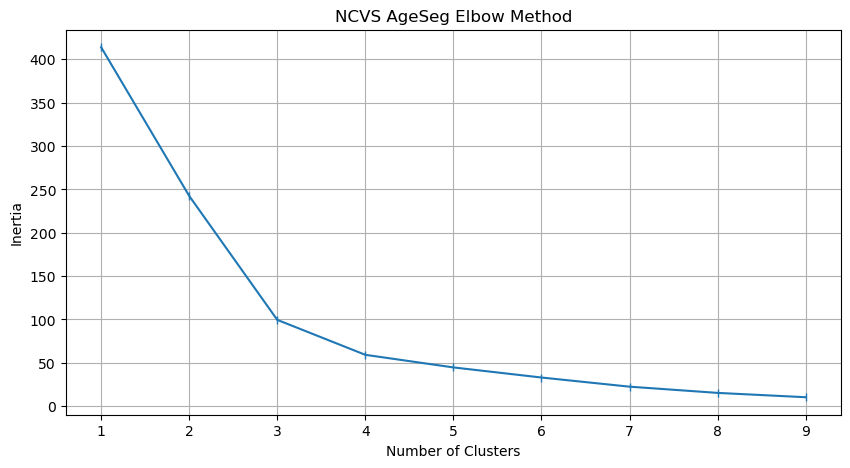

In [28]:
optimise_k_means(NYPD_AgeSeg[['age_gm_T', 'vic_num_T']], 10)

In [30]:
kmeans2= KMeans(n_clusters=3)
kmeans2.fit(NYPD_AgeSeg[['age_gm_T', 'vic_num_T']])

KMeans(n_clusters=3)

In [31]:
NYPD_AgeSeg['kmeans_3'] = kmeans2.labels_
NYPD_AgeSeg

rpt_dt  age_gm  ncic  ct_m  vic_num  age_gm_T    ncic_T  vic_num_T  \
0      2004       1  1101     2        1 -1.573094 -1.023053  -0.229145   
1      2009       1  1101     2        1 -1.573094 -1.023053  -0.229145   
2      2010       1  1101     2        4 -1.573094 -1.023053  -0.227506   
3      2011       1  1101     2        7 -1.573094 -1.023053  -0.225867   
4      2012       1  1101     2       11 -1.573094 -1.023053  -0.223681   
..      ...     ...   ...   ...      ...       ...       ...        ...   
202    2023       6  1201     2      457  1.861826  0.085469   0.019993   
203    2022       6  1301     2        3  1.861826  1.193990  -0.228052   
204    2023       6  1301     2      435  1.861826  1.193990   0.007974   
205    2022       6  1313     1       11  1.861826  1.327013  -0.223681   
206    2023       6  1313     1      668  1.861826  1.327013   0.135275   

     kmeans_3  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
202         2  
203         2  
204         2  
205         2  
206         2  

[207 rows x 9 columns]

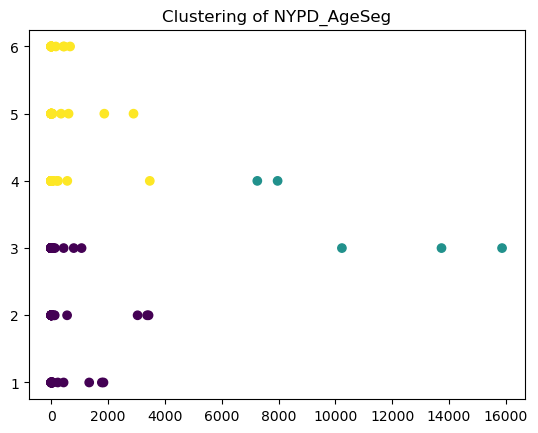

In [34]:
# Creating a kmeans scatter:
plt.scatter(x=NYPD_AgeSeg['vic_num'], y=NYPD_AgeSeg['age_gm'], c=NYPD_AgeSeg['kmeans_3'])
plt.title("Clustering of NYPD_AgeSeg")
plt.show()

In [108]:
#Silhouette Score
# Establishing x by selecting the columns 5 through 7 holding transformed data
x = NYPD_AgeSeg.iloc[:, 5:7].values

model3 = KMeans(n_clusters = 3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = model3.fit_predict(x)
labels = model3.labels_

In [70]:
# Sihouette score
silhouette_score_average = silhouette_score(x, model3.predict(x))
print(silhouette_score_average)

0.4749410238874598


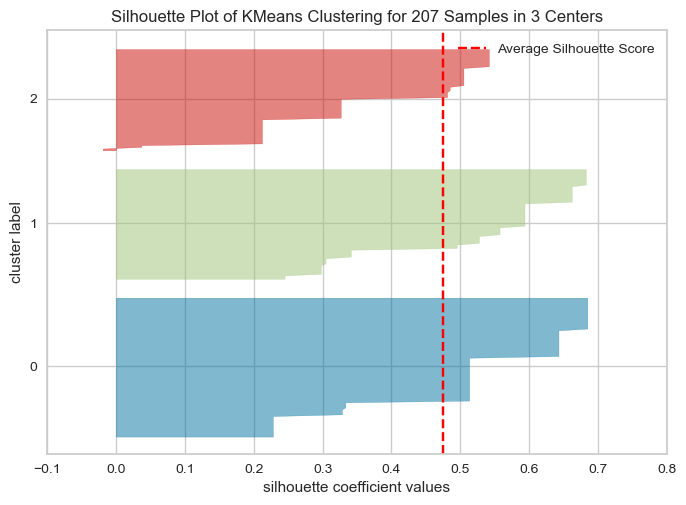

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 207 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [71]:
# Creating a visual of Sihouette:
visualizer = SilhouetteVisualizer(model3, colors='yellowbrick')
visualizer.fit(x)
visualizer.show()

In [109]:
# Calinski-Harabase Index:
ch_score = calinski_harabasz_score(x, labels)

# Davies Boudlin
db_score = davies_bouldin_score(x, labels)

#Silhouette Score:
silhouette_score_average = silhouette_score(x, model3.predict(x))

print(f"The Calinski-Harabasz Score for the NCVS_AgeSeg set is {ch_score}.")
print(f"The Davies-Bouldin Score for the NCVS_AgeSeg set is: {db_score}")
print(f"The Silhouette Score Agerage for the NCVS_AgeSeg set is: {silhouette_score_average}")

The Calinski-Harabasz Score for the NCVS_AgeSeg set is 197.68713137953876.
The Davies-Bouldin Score for the NCVS_AgeSeg set is: 0.8144000086661579
The Silhouette Score Agerage for the NCVS_AgeSeg set is: 0.4749410238874598
